<a href="https://colab.research.google.com/github/alexjmedina/Google-Colab/blob/master/Linear_Regression_in_Healthcare_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression in Healthcare

## Package Imports

In [0]:
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline

In [0]:
from sklearn_pandas import DataFrameMapper
from sklearn import metrics, datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

## Path to the dataset

Link to the dataset : https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Prognostic)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataset_path = "drive/My Drive/Colab Notebooks/data/wpbc.data"

### Attributes present in the dataset

In [0]:
column_names = ['ID','Outcome','Time', 'Radius Mean', 'Texture Mean', 'Perimeter Mean',
       'Area Mean', 'Smoothness Mean', 'Compactness Mean', 'Concavity Mean',
       'Concave Points Mean', 'Symmetry Mean', 'Fractal Dimension Mean',
       'Radius SE', 'Texture SE', 'Perimeter SE', 'Area SE', 'Smoothness SE',
       'Compactness SE', 'Concavity SE', 'Concave Points SE', 'Symmetry SE',
       'Fractal Dimension SE', 'Radius Worst', 'Texture Worst',
       'Perimeter Worst', 'Area Worst', 'Smoothness Worst',
       'Compactness Worst', 'Concavity Worst', 'Concave Points Worst',
       'Symmetry Worst', 'Fractal Dimension Worst', 'Tumor Size', 'Lymph Node Status']

Reading the data into a **Pandas Dataframe**

In [0]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", sep=",")

dataset = raw_dataset.copy()

This is how the data looks like after loading it onto a Pandas Dataframe

In [39]:
dataset.head()

,ID,Outcome,Time,Radius Mean,Texture Mean,Perimeter Mean,Area Mean,Smoothness Mean,Compactness Mean,Concavity Mean,Concave Points Mean,Symmetry Mean,Fractal Dimension Mean,Radius SE,Texture SE,Perimeter SE,Area SE,Smoothness SE,Compactness SE,Concavity SE,Concave Points SE,Symmetry SE,Fractal Dimension SE,Radius Worst,Texture Worst,Perimeter Worst,Area Worst,Smoothness Worst,Compactness Worst,Concavity Worst,Concave Points Worst,Symmetry Worst,Fractal Dimension Worst,Tumor Size,Lymph Node Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5.0
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2.0
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0.0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0.0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0


Number of rows of data present in the dataset are 198.

In [40]:
dataset.shape

(198, 35)

Checking the presence of NA values and dropping them

In [41]:
dataset.isna().sum()

ID                         0
Outcome                    0
Time                       0
Radius Mean                0
Texture Mean               0
Perimeter Mean             0
Area Mean                  0
Smoothness Mean            0
Compactness Mean           0
Concavity Mean             0
Concave Points Mean        0
Symmetry Mean              0
Fractal Dimension Mean     0
Radius SE                  0
Texture SE                 0
Perimeter SE               0
Area SE                    0
Smoothness SE              0
Compactness SE             0
Concavity SE               0
Concave Points SE          0
Symmetry SE                0
Fractal Dimension SE       0
Radius Worst               0
Texture Worst              0
Perimeter Worst            0
Area Worst                 0
Smoothness Worst           0
Compactness Worst          0
Concavity Worst            0
Concave Points Worst       0
Symmetry Worst             0
Fractal Dimension Worst    0
Tumor Size                 0
Lymph Node Sta

In [0]:
dataset = dataset.dropna()

Selecting the data rows in which the disease **has recurred**. 

In [0]:
dataset = dataset[dataset['Outcome'] != 'N']

We have 46 rows where the disease has recurred.

In [44]:
dataset.shape

(46, 35)

Dropping the columns **ID** and **Outcome** as they do not add any value to the model

In [0]:
dataset = dataset.drop('Outcome', 1)
dataset = dataset.drop('ID', 1)

Viewing statistics related to the data attributes

In [46]:
dataset.describe()

,Time,Radius Mean,Texture Mean,Perimeter Mean,Area Mean,Smoothness Mean,Compactness Mean,Concavity Mean,Concave Points Mean,Symmetry Mean,Fractal Dimension Mean,Radius SE,Texture SE,Perimeter SE,Area SE,Smoothness SE,Compactness SE,Concavity SE,Concave Points SE,Symmetry SE,Fractal Dimension SE,Radius Worst,Texture Worst,Perimeter Worst,Area Worst,Smoothness Worst,Compactness Worst,Concavity Worst,Concave Points Worst,Symmetry Worst,Fractal Dimension Worst,Tumor Size,Lymph Node Status
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,25.565217,18.330870,21.758913,121.095217,1081.980435,0.103063,0.141606,0.161542,0.093113,0.187848,0.061176,0.667943,1.200233,4.734978,81.965435,0.006477,0.030801,0.038258,0.014383,0.019904,0.003836,22.670435,29.623913,151.332609,1635.767391,0.145341,0.357509,0.440004,0.183985,0.314017,0.088717,3.471739,4.869565
std,22.727030,3.365566,3.695717,22.910195,397.264721,0.010302,0.040692,0.062138,0.034361,0.021085,0.006298,0.303290,0.426360,2.213389,53.357871,0.001995,0.017501,0.016074,0.003944,0.009174,0.001736,4.703678,5.555203,32.417293,703.147215,0.019605,0.130614,0.147636,0.037977,0.061458,0.016784,2.029851,6.017045
min,1.000000,12.340000,14.340000,81.150000,477.400000,0.082170,0.067220,0.052530,0.033340,0.142400,0.050250,0.220800,0.362100,1.602000,18.850000,0.003978,0.008422,0.016030,0.007299,0.009783,0.001526,15.510000,16.670000,101.700000,733.200000,0.102100,0.120200,0.224900,0.118500,0.229300,0.060910,0.400000,0.000000
25%,9.000000,15.657500,19.067500,103.900000,799.875000,0.094077,0.113375,0.111025,0.067740,0.172175,0.056365,0.427400,0.965225,2.945000,46.805000,0.004739,0.019820,0.023868,0.011505,0.014940,0.002701,19.542500,26.105000,128.300000,1144.250000,0.129775,0.261950,0.323700,0.152850,0.269150,0.076930,2.350000,0.250000
50%,16.500000,18.825000,21.365000,123.550000,1090.000000,0.103350,0.133350,0.164700,0.088235,0.185750,0.060795,0.625750,1.185500,4.298000,67.700000,0.006293,0.027075,0.037500,0.014595,0.017365,0.003460,21.890000,29.470000,145.700000,1481.000000,0.146800,0.352650,0.404900,0.183400,0.304950,0.086945,3.000000,2.000000
75%,36.750000,20.262500,24.162500,133.425000,1278.500000,0.111875,0.166000,0.207525,0.108375,0.198900,0.065240,0.826000,1.369250,5.735750,101.142500,0.007717,0.038780,0.046188,0.016833,0.020975,0.004943,24.870000,33.090000,170.850000,1905.500000,0.160725,0.409550,0.533200,0.208500,0.340700,0.100197,4.000000,7.000000
max,78.000000,27.220000,30.990000,182.100000,2250.000000,0.121500,0.236300,0.336800,0.191300,0.235600,0.074510,1.730000,2.910000,11.560000,316.000000,0.011900,0.100600,0.097230,0.026380,0.053330,0.010390,35.130000,40.140000,232.200000,3903.000000,0.185100,0.744400,0.734500,0.275600,0.488200,0.134100,10.000000,27.000000


### We will be building three models in this tutorial
Model 1: A baseline model. 

Model 2: A model with a single attribute as the predictor.

Model 3: A model with basic feature engineering involved.

In [0]:
baseline_dataset = dataset
baseline_dataset = baseline_dataset.drop('Time', axis = 1)

For building Model 2 and Model 3 let's do some analysis first.

We begin by building a correlation heatmap amongst the attributes to check which attributes have a strong relationship with our response variable **Time**.

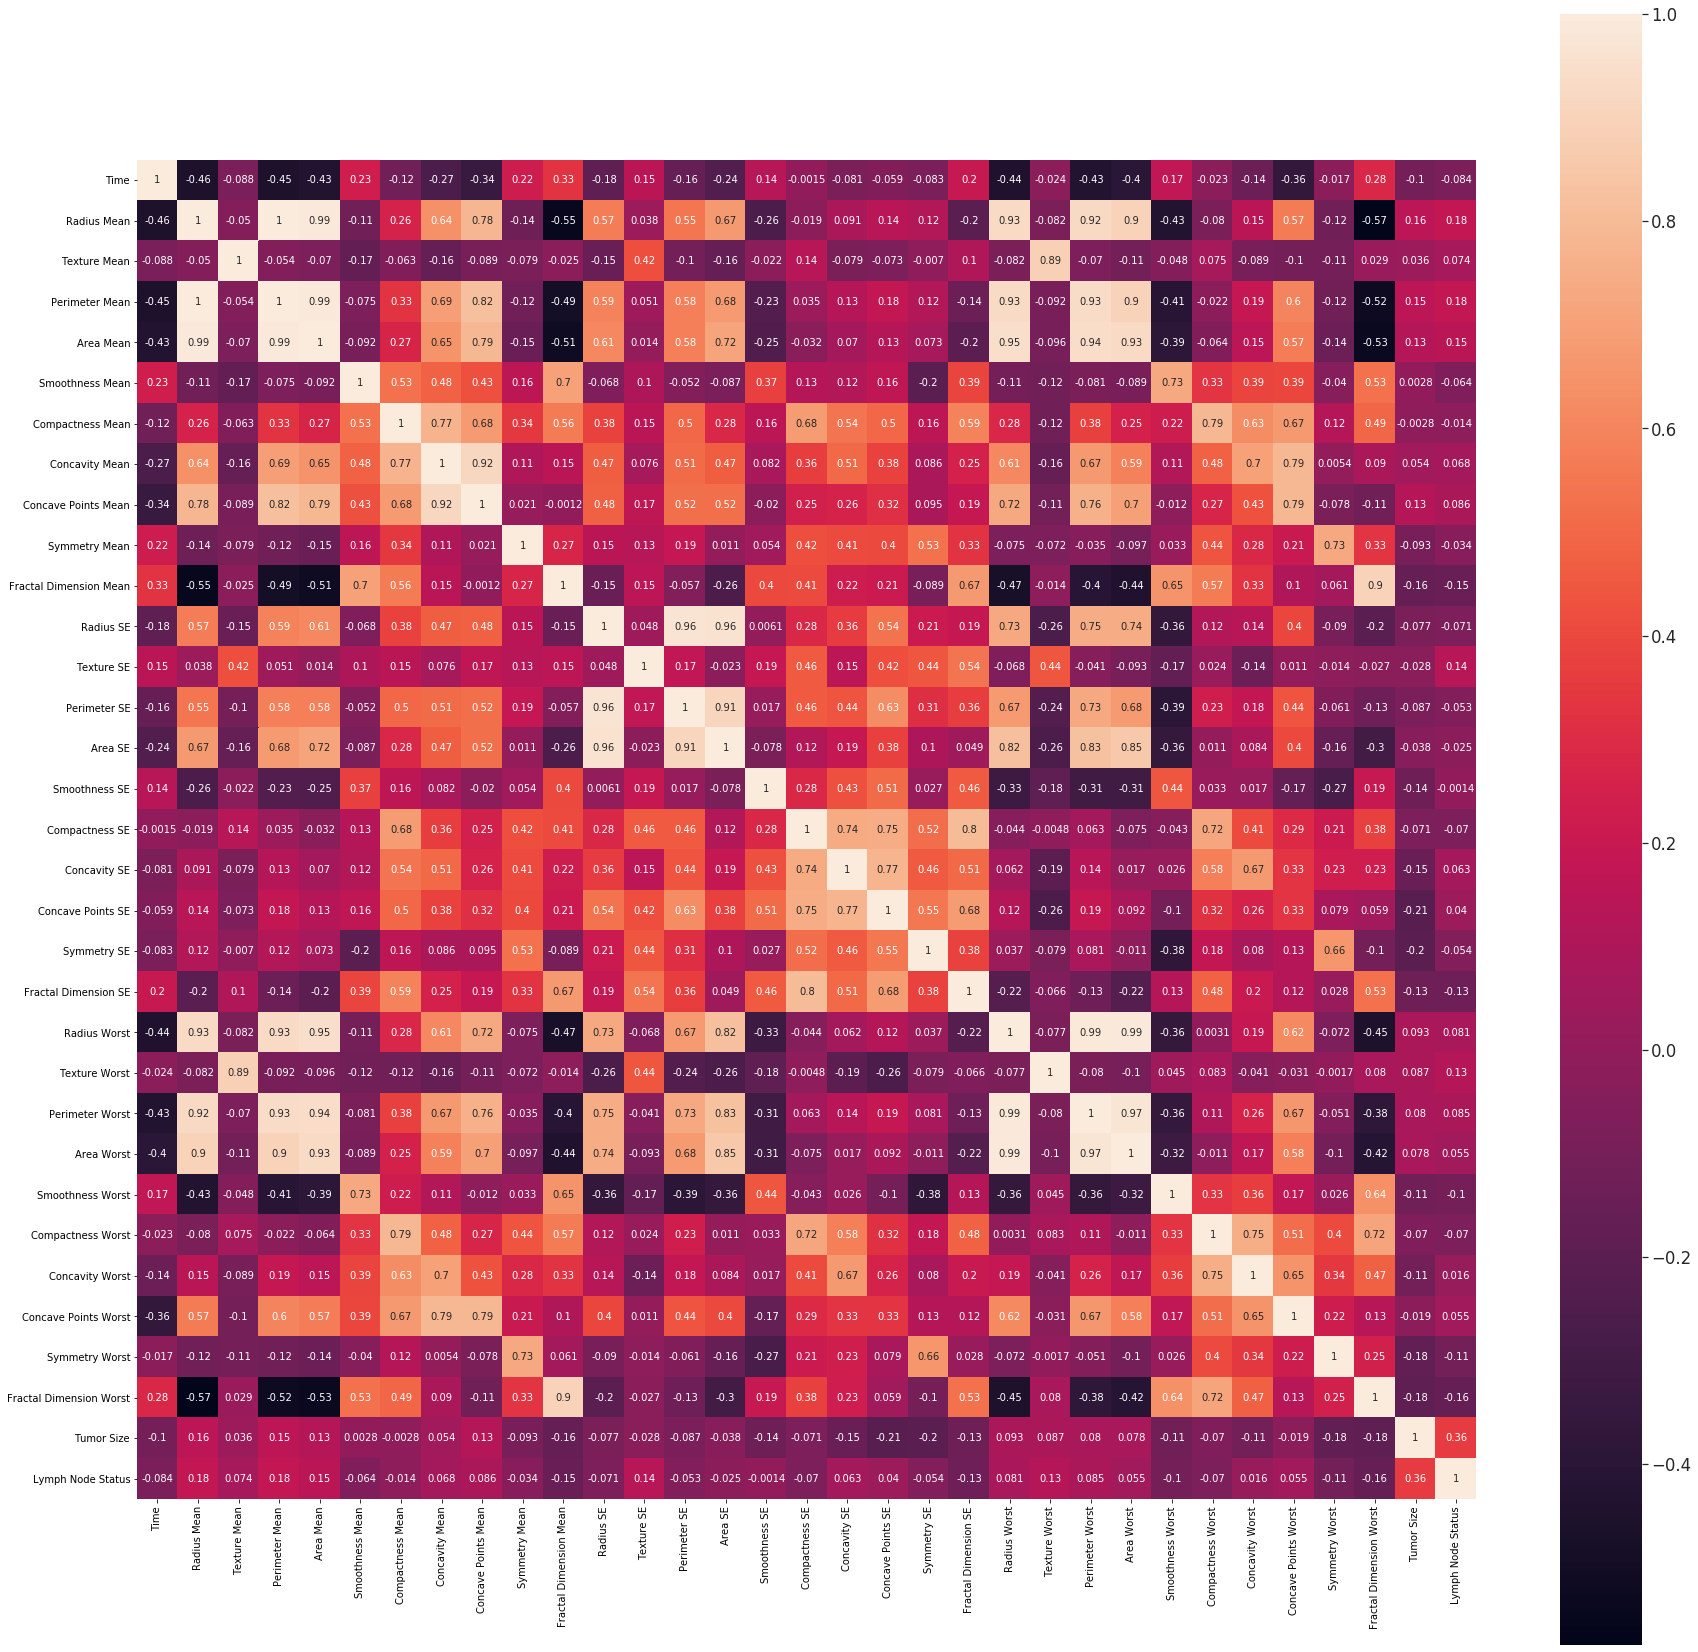

In [48]:
fig = plt.subplots(figsize = (30, 30))
sns.set(font_scale=1.5)
sns.heatmap(dataset.corr(),square = True,cbar=True,annot=True,annot_kws={'size': 10})
plt.savefig("Correlation_All_Attributes.png")

For the single attribute, we choose **Radius Mean** as it is highly correlated(negative correlation) attribute with **Time**.

In [0]:
single_attribute_dataset = dataset[['Radius Mean']]

Next, for the feature engineered model we drop the predictors that are highly correlated with other predictors to avoid the problems associated with **multicollinearity**.

In [50]:
drop_list = ['Texture Mean', 'Perimeter Mean', 'Area Mean','Compactness Mean', 'Smoothness Mean', 'Concavity Mean', 'Symmetry Mean',
             'Radius SE','Perimeter SE', 'Area SE', 'Texture SE', 'Compactness SE', 'Smoothness SE', 'Concavity SE', 'Concave Points SE', 'Fractal Dimension SE', 'Symmetry SE',
             'Area Worst','Perimeter Worst','Compactness Worst', 'Concavity Worst', 'Fractal Dimension Worst', 'Symmetry Worst',
             'Concave Points Worst','Texture Worst','Lymph Node Status', 'Tumor Size']
feature_engineer_dataset = dataset.drop(drop_list,axis = 1 )
feature_engineer_dataset.head()

,Time,Radius Mean,Concave Points Mean,Fractal Dimension Mean,Radius Worst,Smoothness Worst
4,27,20.29,0.10430,0.05883,22.54,0.1374
5,77,12.75,0.07666,0.07164,15.51,0.1706
7,77,13.71,0.05985,0.07451,17.06,0.1654
13,36,14.54,0.07364,0.07077,17.46,0.1678
15,10,16.13,0.10280,0.07356,20.96,0.1789


We will also standardize all the features

In [0]:
labels = feature_engineer_dataset.pop('Time')
mapper = DataFrameMapper([(feature_engineer_dataset.columns, StandardScaler())])
scaled_features = mapper.fit_transform(feature_engineer_dataset.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=feature_engineer_dataset.index, columns=feature_engineer_dataset.columns)

In [52]:
scaled_features_df.describe()

,Radius Mean,Concave Points Mean,Fractal Dimension Mean,Radius Worst,Smoothness Worst
count,4.600000e+01,4.600000e+01,4.600000e+01,4.600000e+01,4.600000e+01
mean,-1.010363e-15,4.827057e-18,-4.875327e-16,3.209993e-16,1.858417e-15
std,1.011050e+00,1.011050e+00,1.011050e+00,1.011050e+00,1.011050e+00
min,-1.799718e+00,-1.758806e+00,-1.754040e+00,-1.539127e+00,-2.230010e+00
25%,-8.031072e-01,-7.465950e-01,-7.723375e-01,-6.723460e-01,-8.027743e-01
50%,1.484418e-01,-1.435351e-01,-6.114484e-02,-1.677536e-01,7.522681e-02
75%,5.802813e-01,4.490790e-01,6.524560e-01,4.727940e-01,7.933569e-01
max,2.670385e+00,2.889125e+00,2.140663e+00,2.678169e+00,2.050407e+00


### Building the Linear Regression Models

In [0]:
def build_and_evaluate_model(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    print('Coefficients: \n', regr.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("The labels: \n", np.array(y_test).astype(int))
    print("The predicted values are: \n", y_pred.astype(int))

### Model 1 - The baseline model

In [54]:
build_and_evaluate_model(baseline_dataset, labels)

Coefficients: 
 [ 1.87558624e+02 -4.31539147e+00 -1.73947890e+01 -4.94425769e-01
  1.56621029e+03  6.05271690e+02 -7.96341467e+02  1.67151688e+03
  1.34832465e+03 -4.31970515e+03 -1.87843385e+02  3.24898861e+01
  1.92898934e+01  4.45130613e-01 -4.92331650e+03 -3.17053422e+03
  1.54404111e+03  1.25318223e+03  2.72691577e+03 -8.10700391e+03
 -4.17474118e+01  1.20085811e+00 -3.53058473e-02  2.34189011e-01
  1.21288291e+02  4.27111091e+02  3.93781602e+01 -1.46054410e+03
 -8.30320353e+02  3.09760404e+03 -5.93312272e+00 -8.65647715e-01]
Mean squared error: 4872.55
The labels: 
 [ 9 12 37 14 49 12 10 26 48 36]
The predicted values are: 
 [ 52 -12 -92 -39  -3  53  48  83 -26 144]


### Model 2 - A single predictor model

In [55]:
build_and_evaluate_model(single_attribute_dataset, labels)

Coefficients: 
 [-3.24702754]
Mean squared error: 223.75
The labels: 
 [ 9 12 37 14 49 12 10 26 48 36]
The predicted values are: 
 [23 30 31 29 36 28 34 42 37 39]


### Model 3 - A feature engineered model

In [56]:
build_and_evaluate_model(feature_engineer_dataset, labels)

Coefficients: 
 [ 1.23368259e+00 -1.61054494e+02  1.41158684e+03 -1.66161798e+00
 -1.52751714e+02]
Mean squared error: 280.71
The labels: 
 [ 9 12 37 14 49 12 10 26 48 36]
The predicted values are: 
 [19 28 22 26 33 32 38 45 35 44]
